# Preprocessing - encoding, discretization, dtypes

Before performing All Relevant Feature Selection, you might want to apply preprocessing as:

 - ordinal encoding (recommended over other encoding strategies)
 - discretization and auto-grouping of levels
 - select columns in a consistent fashion, according data types and patterns

Ordinal encoding is strongly recommended for GBM-based methods. It is well documented that GBMs generally return better results when categorical predictors are encoded as integers (see lightGBM documentation for instance). OHE should be avoided since it leads to shallow trees.

Auto-grouping levels of categorical predictors and discretization of continuous ones is achieved using a method using GBMs, specifically lightGBM. LightGBM is extremely efficient at building histograms and finding the best splits. Leveraging the inner working of lightGBM, it is fairly simple and blazing fast to discretize and auto-group the predictor matrix.  


In [18]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [19]:
# Settings and libraries
from __future__ import print_function

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import gc

import arfs
import arfs.preprocessing as arfspp
from arfs.utils import (
    _generated_corr_dataset_regr,
    _generated_corr_dataset_classification,
)

%matplotlib inline

In [20]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 1.0.4


In [21]:
arfspp.__all__

['OrdinalEncoderPandas', 'dtype_column_selector', 'TreeDiscretizer']

## Generating artificial data

Inspired by the BorutaPy unit test

In [22]:
X, y, w = _generated_corr_dataset_regr()
data = X.copy()
data["target"] = y

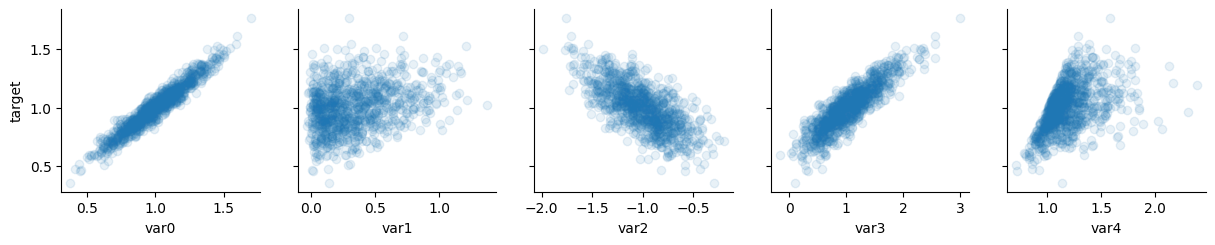

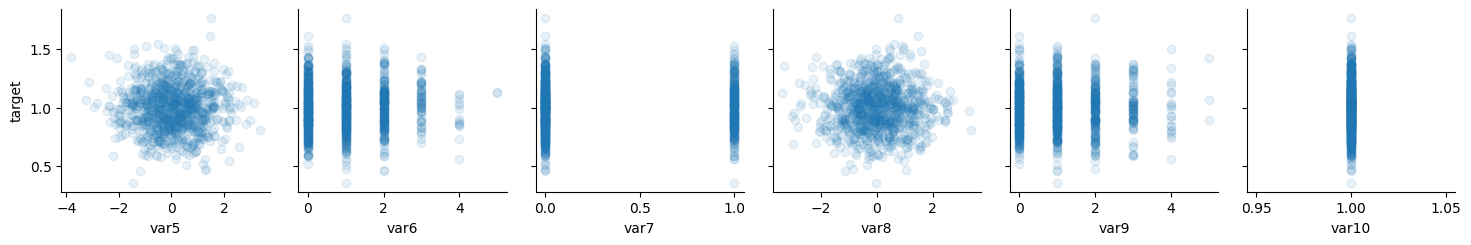

In [23]:
# significant regressors
x_vars = ["var0", "var1", "var2", "var3", "var4"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

# noise
x_vars = ["var5", "var6", "var7", "var8", "var9", "var10"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

plt.plot();

In [24]:
X.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,dummy_cat,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2.0,0.0,-0.361717,1.0,1.0,0.0,NaN,Bane
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1.0,0.0,0.178670,2.0,1.0,1.0,1.187347,Bias
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2.0,0.0,-3.375579,2.0,1.0,2.0,NaN,Bane
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0.0,0.0,-0.449650,2.0,1.0,3.0,NaN,Dracula
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1.0,0.0,0.763903,1.0,1.0,4.0,2.317360,SAS


In [25]:
X.dtypes

var0          float64
var1          float64
var2          float64
var3          float64
var4          float64
var5          float64
var6          float64
var7          float64
var8          float64
var9          float64
var10         float64
dummy_cat    category
var12         float64
nice_guys      object
dtype: object

## Selecting columns

The custome selector returns a callable (function) which will return the list of column names.

In [26]:
from arfs.preprocessing import dtype_column_selector

cat_features_selector = dtype_column_selector(
    dtype_include=["category", "object", "bool"],
    dtype_exclude=[np.number],
    pattern=None,
    exclude_cols=None,
)

cat_features_selector(X)

['dummy_cat', 'nice_guys']

## Encoding categorical data

Unlike to scikit-learn, you don't need to build a custom ColumnTransformer. You can just throw in a dataframe and it will return the same dataframe with the relevant columns encoded.
You can:

 - fit
 - transform
 - fit_transform
 - inverse_transform
 - use it in a Pipeline


as you will do in vanilla scikit-learn.

In [27]:
from arfs.preprocessing import OrdinalEncoderPandas

encoder = OrdinalEncoderPandas(exclude_cols=["nice_guys"]).fit(X)
X_encoded = encoder.transform(X)

In [28]:
X_encoded.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,dummy_cat,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2.0,0.0,-0.361717,1.0,1.0,0.0,NaN,Bane
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1.0,0.0,0.178670,2.0,1.0,1.0,1.187347,Bias
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2.0,0.0,-3.375579,2.0,1.0,2.0,NaN,Bane
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0.0,0.0,-0.449650,2.0,1.0,3.0,NaN,Dracula
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1.0,0.0,0.763903,1.0,1.0,4.0,2.317360,SAS


In [29]:
encoder.inverse_transform(X_encoded)

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,dummy_cat,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2.0,0.0,-0.361717,1.0,1.0,0.0,NaN,Bane
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1.0,0.0,0.178670,2.0,1.0,1.0,1.187347,Bias
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2.0,0.0,-3.375579,2.0,1.0,2.0,NaN,Bane
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0.0,0.0,-0.449650,2.0,1.0,3.0,NaN,Dracula
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1.0,0.0,0.763903,1.0,1.0,4.0,2.317360,SAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.904073,0.009764,-0.909486,0.831147,1.041658,0.081291,0.0,0.0,-0.542799,3.0,1.0,495.0,1.199386,Gruber
996,1.370908,1.144173,-1.129008,2.002148,1.418488,0.484591,0.0,1.0,-1.932372,1.0,1.0,496.0,3.670311,Vador
997,1.113773,0.206798,-1.371649,1.167287,1.079760,0.267475,0.0,0.0,-0.329798,0.0,1.0,497.0,NaN,Klaue
998,0.905654,0.598419,-0.792174,0.783557,1.275266,0.380826,1.0,0.0,-1.987310,1.0,1.0,498.0,1.363285,Coldplay


In [30]:
X.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,dummy_cat,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2.0,0.0,-0.361717,1.0,1.0,0.0,NaN,Bane
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1.0,0.0,0.178670,2.0,1.0,1.0,1.187347,Bias
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2.0,0.0,-3.375579,2.0,1.0,2.0,NaN,Bane
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0.0,0.0,-0.449650,2.0,1.0,3.0,NaN,Dracula
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1.0,0.0,0.763903,1.0,1.0,4.0,2.317360,SAS


In [31]:
X.nunique()

var0         1000
var1         1000
var2         1000
var3         1000
var4         1000
var5         1000
var6            6
var7            2
var8         1000
var9            6
var10           1
dummy_cat     500
var12         500
nice_guys      36
dtype: int64

## Discretization and auto-grouping

Discretization and auto-grouping are supervised tasks and therefore require a target, and optionally a weight.

In [32]:
from arfs.preprocessing import TreeDiscretizer

# main parameter controlling how agressive will be the auto-grouping
lgb_params = {"min_split_gain": 0.05}
# instanciate the discretizer
disc = TreeDiscretizer(bin_features="all", n_bins=10, boost_params=lgb_params)

disc.fit(X=X, y=y, sample_weight=w)

TreeDiscretizer(bin_features=['var0', 'var1', 'var2', 'var3', 'var4', 'var5',
                              'var6', 'var7', 'var8', 'var9', 'var10',
                              'dummy_cat', 'var12', 'nice_guys'],
                boost_params={'max_leaf': 10, 'min_split_gain': 0.05,
                              'num_boost_round': 1, 'objective': 'RMSE'})

The regularization `min_split_gain` has as an outcome, as expected, to auto-group into a single level all the predictors not correlated to the target.  

In [33]:
X_trans = disc.transform(X)
X_trans

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,dummy_cat,var12,nice_guys
0,"(1.0, 1.1]","(0.6, 0.85]","(-1.3, -1.1]","(0.8, 1.0]","(1.0, 1.06]","(-1.0, -0.2]","(1.0, inf]","(-inf, inf]","(-1.4, -0.0005]","(-inf, inf]","(-inf, inf]",0.0 / 1.0 / 2.0 / 3.0 / 4.0 / 5.0 / 6.0 / 7.0 ...,"(1.5, 2.0]",Bane / Bias / Dracula / SAS / Terminator / Lec...
1,"(0.9, 1.0]","(0.32, 0.35]","(-1.1, -1.0]","(0.7, 0.8]","(1.0, 1.06]","(0.08, 0.3]","(-inf, 1.0]","(-inf, inf]","(-0.0005, 0.2]","(-inf, inf]","(-inf, inf]",0.0 / 1.0 / 2.0 / 3.0 / 4.0 / 5.0 / 6.0 / 7.0 ...,"(0.9, 1.5]",Bane / Bias / Dracula / SAS / Terminator / Lec...
2,"(1.1, 1.2]","(0.17, 0.27]","(-1.6, -1.3]","(1.0, 1.1]","(1.13, 1.34]","(0.7, 1.5]","(1.0, inf]","(-inf, inf]","(-inf, -1.9]","(-inf, inf]","(-inf, inf]",0.0 / 1.0 / 2.0 / 3.0 / 4.0 / 5.0 / 6.0 / 7.0 ...,"(1.5, 2.0]",Bane / Bias / Dracula / SAS / Terminator / Lec...
3,"(1.3, 1.4]","(0.85, inf]","(-1.6, -1.3]","(1.4, 1.6]","(1.13, 1.34]","(0.7, 1.5]","(-inf, 1.0]","(-inf, inf]","(-1.4, -0.0005]","(-inf, inf]","(-inf, inf]",0.0 / 1.0 / 2.0 / 3.0 / 4.0 / 5.0 / 6.0 / 7.0 ...,"(1.5, 2.0]",Bane / Bias / Dracula / SAS / Terminator / Lec...
4,"(0.8, 0.9]","(0.17, 0.27]","(-0.9, -0.6]","(0.8, 1.0]","(0.9, 1.0]","(-0.1, 0.08]","(-inf, 1.0]","(-inf, inf]","(0.7, 1.0]","(-inf, inf]","(-inf, inf]",0.0 / 1.0 / 2.0 / 3.0 / 4.0 / 5.0 / 6.0 / 7.0 ...,"(2.0, 2.7]",Bane / Bias / Dracula / SAS / Terminator / Lec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"(0.9, 1.0]","(-inf, 0.17]","(-1.0, -0.9]","(0.7, 0.8]","(1.0, 1.06]","(-0.1, 0.08]","(-inf, 1.0]","(-inf, inf]","(-1.4, -0.0005]","(-inf, inf]","(-inf, inf]",468.0 / 469.0 / 470.0 / 471.0 / 472.0 / 473.0 ...,"(0.9, 1.5]",Bane / Bias / Dracula / SAS / Terminator / Lec...
996,"(1.3, 1.4]","(0.85, inf]","(-1.3, -1.1]","(1.8, inf]","(1.42, inf]","(0.4, 0.6]","(-inf, 1.0]","(-inf, inf]","(-inf, -1.9]","(-inf, inf]","(-inf, inf]",468.0 / 469.0 / 470.0 / 471.0 / 472.0 / 473.0 ...,"(3.2, inf]",Bane / Bias / Dracula / SAS / Terminator / Lec...
997,"(1.1, 1.2]","(0.17, 0.27]","(-1.6, -1.3]","(1.1, 1.3]","(1.06, 1.13]","(0.08, 0.3]","(-inf, 1.0]","(-inf, inf]","(-1.4, -0.0005]","(-inf, inf]","(-inf, inf]",468.0 / 469.0 / 470.0 / 471.0 / 472.0 / 473.0 ...,"(1.5, 2.0]",Bane / Bias / Dracula / SAS / Terminator / Lec...
998,"(0.9, 1.0]","(0.45, 0.6]","(-0.9, -0.6]","(0.7, 0.8]","(1.13, 1.34]","(0.3, 0.4]","(-inf, 1.0]","(-inf, inf]","(-inf, -1.9]","(-inf, inf]","(-inf, inf]",468.0 / 469.0 / 470.0 / 471.0 / 472.0 / 473.0 ...,"(0.9, 1.5]",Bane / Bias / Dracula / SAS / Terminator / Lec...


## Sklearn Pipeline

The selectors follow the scikit-learn base class, therefore they are compatible with scikit-learn in general.
This has several advantages:
 - easier to maintain
 - easier to version
 - more flexible
 - running faster by removing unnecessary columns before going to the computational demanding steps


In [34]:
from sklearn.pipeline import Pipeline
from arfs.preprocessing import OrdinalEncoderPandas
from arfs.feature_selection import CollinearityThreshold

encoder = Pipeline(
    [
        ("collinearity", CollinearityThreshold(threshold=0.75)),
        (
            "disctretizer",
            TreeDiscretizer(bin_features="all", n_bins=10, boost_params=lgb_params),
        ),
        ("encoder", OrdinalEncoderPandas()),
    ]
)

X_encoded = encoder.fit(X, y).transform(X)
X_encoded.head()

{'var10'} columns have been removed (single unique values)


,var1,var3,var5,var6,var7,var8,var9,var10
0,8.0,4.0,0.0,1.0,0.0,3.0,0.0,0.0
1,3.0,3.0,4.0,0.0,0.0,5.0,0.0,0.0
2,2.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0
3,9.0,7.0,7.0,0.0,0.0,2.0,0.0,0.0
4,2.0,3.0,3.0,0.0,0.0,7.0,0.0,0.0
